###	Define Hypothesis

We want to compare whether group $i$ th is more than group $j$ th, so we use one sided (right tail) hypothesis testing.

we want to prove whether the conversion rate of group $j$ is greater than the conversion rate of group $i$

The hypothesis for each group pair is as follows:
- group 1 vs group 2
    $$H_0 : p_B \leq p_A$$
    $$H_1 : p_B > p_A$$

- group 1 vs group 3
    $$H_0 : p_C \leq p_A$$
    $$H_1 : p_C > p_A$$

- group 1 vs group 4
    $$H_0 : p_D \leq p_A$$
    $$H_1 : p_D > p_A$$

- group 2 vs group 3
    $$H_0 : p_C \leq p_B$$
    $$H_1 : p_C > p_B$$

- group 2 vs group 4
    $$H_0 : p_D \leq p_B$$
    $$H_1 : p_D > p_B$$

- group 3 vs group 4
    $$H_0 : p_D \leq p_C$$
    $$H_1 : p_D > p_C$$
    

#### • Calculating Sample Size

#### How many minimum sample size are needed when $\alpha=5 \%$ and power 80%?

- Remember, we can use the given formula to calculate the minimum number of sample size needed.

$$
n = \cfrac{2 \sigma^2 (z_{1-\alpha/2}+z_{1-\beta})^2}{\delta^2}
$$

- Thus, if we have the $z$ value, we can determine the number of sample.


In [61]:
pip install pyodbc

Note: you may need to restart the kernel to use updated packages.


In [62]:
pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [63]:
import pyodbc as pyodbc
import pandas as pd
from sqlalchemy import create_engine

In [64]:
import numpy as np
import seaborn as sns
from scipy import stats
import scipy.stats as st
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt

In [65]:
# Given
delta = 0.01        # absolute increase of groups means
alpha = 0.05        # significance level
power = 0.8         # power
std_dev = 0.2      # variance of population (assumed / approximated)

In [66]:
# calculate beta
beta = 1 - power
beta

0.19999999999999996

In [67]:
# calculate the z value
z_alpha = stats.norm.ppf(1 - alpha/2)
z_beta = stats.norm.ppf(1 - beta)

z_alpha, z_beta

(1.959963984540054, 0.8416212335729143)

In [68]:
# then calculate the number of sample size
n = 2 * (std_dev**2) * ((z_alpha+z_beta)**2) / (delta**2)

print(f"Number of sample size needed    : {n:.2f}")

Number of sample size needed    : 6279.10


# Extract Data From SQL Server

In [69]:


connection_string = 'mssql+pyodbc://DESKTOP-KOO9GIJ\\MSSQLSERVER01/ads?driver=ODBC+Driver+17+for+SQL+Server'

engine = create_engine(connection_string)


In [70]:
query = ''' 
WITH ranked_offers AS (
    SELECT 
        [offer],
        [customer_id],
        [event],
        [time],
        [Amount],
        [OfferId],
        [offer_type],
        [duration],
        ROW_NUMBER() OVER (PARTITION BY [customer_id], [OfferId] ORDER BY [time]) AS offer_sequence
    FROM [ads].[dbo].[new_data]
    WHERE [event] = 'offer received'
)
, cc as (
SELECT 
    CASE 
        WHEN nd.[event] = 'offer received' 
        THEN CONCAT(nd.[OfferId], '_', ro.offer_sequence) 
        ELSE nd.[OfferId] 
    END AS final_offer_id
	,nd.*
FROM [ads].[dbo].[new_data] nd
LEFT JOIN ranked_offers ro
    ON nd.[customer_id] = ro.[customer_id] 
    AND nd.[OfferId] = ro.[OfferId]
    AND nd.[time] = ro.[time]
	)
,r as  ( 
    SELECT 
		CONCAT(customer_id, '_', OfferId, '_', CAST(time AS VARCHAR)) AS new_id,
        OfferId,
        customer_id
    FROM 
        cc
    WHERE 
         event = 'offer completed' or offer = 'Transaction With Offer' or offer_type = 'informational'
)
,c as ( 
SELECT 
	CONCAT(customer_id, '_', OfferId, '_', CAST(time AS VARCHAR)) AS new_id,
	case when event = 'transaction' then time else null end as time_transaction,
    nd.*
FROM 
    cc AS nd
	where event != 'offer viewed' 
), dc as 
( 
select c.* from c
where   
     NOT EXISTS (
        SELECT 1
        FROM r 
        WHERE 
		(r.customer_id = c.customer_id AND r.OfferId = c.OfferId)  

    )  

), kk as (
select dc.* from dc
where NOT EXISTS ( SELECT 1 FROM r WHERE r.new_id = dc.new_id  ) 


)
, gabung as (
select 
[offer]
      ,[customer_id]
      ,[event]
      ,[time]
      ,[Amount]
      ,[OfferId]
      ,[reward_get]
      ,[Tahun]
      ,[Bulan]
      ,[Tanggal]
      ,[became_member_on]
      ,[gender]
      ,[age]
      ,[income]
      ,[offer_type]
from kk
where event = 'offer received'
union all 
SELECT 
		[offer]
      ,[customer_id]
      ,[event]
      ,[time]
      ,[Amount]
      ,[OfferId]
      ,[reward_get]
      ,[Tahun]
      ,[Bulan]
      ,[Tanggal]
      ,[became_member_on]
      ,[gender]
      ,[age]
      ,[income]
      ,[offer_type]
  FROM [ads].[dbo].[new_data]
  where offer = 'Transaction With Offer' 
  )
  select 
  g.*, ofs.[difficulty]
      ,ofs.[reward]
      ,ofs.[duration]
      ,ofs.[channels]
	  , CASE 
        WHEN [OfferId] ='ae264e3637204a6fb9bb56bc8210ddfd' THEN 'A'
        WHEN [OfferId] = '4d5c57ea9a6940dd891ad53e9dbe8da0' THEN 'B'
        WHEN [OfferId] = '9b98b8c7a33c4b65b9aebfe6a799e6d9'THEN 'C'
        WHEN [OfferId] = 'f19421c1d4aa40978ebb69ca19b0e20d' THEN 'D'
        WHEN [OfferId] = '0b1e1539f2cc45b7b9fa7c272da2e1d7' THEN 'E'
        WHEN [OfferId] = '2298d6c36e964ae4a3e7e9706d1fb8c2' THEN 'F'
        WHEN [OfferId] =  'fafdcd668e3743c1bb461111dcafc2a4'THEN 'G'
        WHEN [OfferId] = '2906b810c7d4411798c6938adc9daaa5' THEN 'H'
        ELSE 'Unknown Group'
    END AS groups
    ,case when g.offer = 'Offer' then 0 else 1 end conver
  from gabung as g
  inner join [ads].[dbo].[offers] as ofs
  on g.[OfferId] = ofs.[offer_id]
  '''

In [71]:
# Eksekusi query menggunakan pandas
df = pd.read_sql(query, engine)
df

,offer,customer_id,event,time,Amount,OfferId,reward_get,Tahun,Bulan,Tanggal,...,gender,age,income,offer_type,difficulty,reward,duration,channels,groups,conver
0,Offer,00116118485d4dfda04fdbaba9a87b5c,offer received,168.0,,f19421c1d4aa40978ebb69ca19b0e20d,None,2018,04,25,...,None,118.0,NaN,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
1,Offer,00116118485d4dfda04fdbaba9a87b5c,offer received,576.0,,f19421c1d4aa40978ebb69ca19b0e20d,None,2018,04,25,...,None,118.0,NaN,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
2,Offer,0020c2b971eb4e9188eac86d93036a77,offer received,168.0,,ae264e3637204a6fb9bb56bc8210ddfd,None,2016,03,04,...,F,59.0,90000.0,bogo,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
3,Offer,00426fe3ffde4c6b9cb9ad6d077a13ea,offer received,336.0,,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,2016,08,09,...,F,19.0,65000.0,discount,20.0,5.0,10.0,"['web', 'email']",E,0
4,Offer,00426fe3ffde4c6b9cb9ad6d077a13ea,offer received,408.0,,2906b810c7d4411798c6938adc9daaa5,None,2016,08,09,...,F,19.0,65000.0,discount,10.0,2.0,7.0,"['web', 'email', 'mobile']",H,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54951,Transaction With Offer,ffdefcac307f4ca99ac1ebd51470f106,transaction,54.0,24.41,fafdcd668e3743c1bb461111dcafc2a4,None,2017,03,15,...,F,87.0,47000.0,discount,10.0,2.0,10.0,"['web', 'email', 'mobile', 'social']",G,1
54952,Transaction With Offer,fff3ba4757bd42088c044ca26d73817a,transaction,6.0,20.98,fafdcd668e3743c1bb461111dcafc2a4,None,2015,09,20,...,F,69.0,83000.0,discount,10.0,2.0,10.0,"['web', 'email', 'mobile', 'social']",G,1
54953,Transaction With Offer,fff7576017104bcc8677a8d63322b5e1,transaction,192.0,5.99,fafdcd668e3743c1bb461111dcafc2a4,None,2017,10,31,...,M,71.0,73000.0,discount,10.0,2.0,10.0,"['web', 'email', 'mobile', 'social']",G,1
54954,Transaction With Offer,fff7576017104bcc8677a8d63322b5e1,transaction,594.0,8.01,fafdcd668e3743c1bb461111dcafc2a4,None,2017,10,31,...,M,71.0,73000.0,discount,10.0,2.0,10.0,"['web', 'email', 'mobile', 'social']",G,1


# Topic Review

**Multivariate Testing** adalah eksperimen yang menguji lebih dari satu variabel atau elemen secara bersamaan, untuk memahami efeknya.

**Multivariate Testing** **berbeda** dari A/B/N Testing:
- **A/B/N Testing** mirip dengan A/B Testing tetapi memiliki N (lebih dari dua) versi, dengan perubahan radikal atau versi untuk melihat versi mana yang terbaik.
- **Multivariate Testing** melibatkan pemilihan sejumlah elemen pada halaman dan menguji berbagai kombinasi dari elemen tersebut secara bersamaan untuk memahami kombinasi mana yang memberikan hasil terbaik.

**Berikut adalah ringkasan perbedaan utama antara A/B/N Testing dan Multivariate Testing:**

| | A/B atau A/B/N Testing | Multivariate Testing |
|:--|:--:|:--:|
| **Apa yang dapat diuji?** | Tata letak, desain, atau perubahan pada elemen tunggal | Efek dari perubahan kombinasi elemen |
| **Jumlah Trafik yang Diperlukan** | Relatif rendah | Tinggi |
| **Waktu yang Diperlukan untuk Hasil yang Bermakna** | Pendek | Secara signifikan lebih lama |
| **Terbaik Digunakan untuk** | Tata letak & desain yang berbeda secara signifikan atau situs dengan trafik rendah | Mengoptimalkan kombinasi elemen |


- **Masalah Pengujian Hipotesis Ganda**

  - Jika kita memiliki lebih dari dua kelompok varian dalam eksperimen kita, untuk menganalisis hasilnya, kita akan melakukan **pengujian hipotesis ganda**.
  - Namun, ada masalah dalam melakukan pengujian hipotesis ganda. Masalah utamanya adalah **peningkatan kesalahan Tipe I**.
  - Untuk mengatasi hal ini, kita memerlukan koreksi dengan **metode koreksi Benjamini-Hochberg**.


## Case Cafe Rewards

- XYZ Company adalah sebuah kafe yang menjual berbagai produk melalui situs web.
- Mereka ingin mengidentifikasi reward yang diberikan kepada para pengguna.
- Mereka ingin melihat reward apa yang paling efisien.

dilakukan filtering untuk melakukan testing multivariat untuk tipe Offer BOGO

In [72]:
bogo_df = df[df['offer_type'] == 'bogo']

In [73]:
bogo_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27406 entries, 0 to 50142
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   offer             27406 non-null  object 
 1   customer_id       27406 non-null  object 
 2   event             27406 non-null  object 
 3   time              27406 non-null  float64
 4   Amount            27406 non-null  object 
 5   OfferId           27406 non-null  object 
 6   reward_get        0 non-null      object 
 7   Tahun             27406 non-null  object 
 8   Bulan             27406 non-null  object 
 9   Tanggal           27406 non-null  object 
 10  became_member_on  27406 non-null  float64
 11  gender            23593 non-null  object 
 12  age               27406 non-null  float64
 13  income            23593 non-null  float64
 14  offer_type        27406 non-null  object 
 15  difficulty        27406 non-null  float64
 16  reward            27406 non-null  float64
 17

In [74]:
grouped_df = bogo_df.groupby(['OfferId', 'offer_type','offer']).size().reset_index(name='total_rows').sort_values(by=['offer_type'])
grouped_df

,OfferId,offer_type,offer,total_rows
0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,Offer,4005
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,Transaction With Offer,2922
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,Offer,2957
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,Transaction With Offer,3868
4,ae264e3637204a6fb9bb56bc8210ddfd,bogo,Offer,3725
5,ae264e3637204a6fb9bb56bc8210ddfd,bogo,Transaction With Offer,3251
6,f19421c1d4aa40978ebb69ca19b0e20d,bogo,Offer,2890
7,f19421c1d4aa40978ebb69ca19b0e20d,bogo,Transaction With Offer,3788


In [75]:
# Seleksi kolom tertentu dari DataFrame
bogo_df = bogo_df[['customer_id', 'OfferId', 'difficulty', 'reward', 'duration', 'channels','groups', 'conver']]

# Tampilkan hasil
bogo_df


,customer_id,OfferId,difficulty,reward,duration,channels,groups,conver
0,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
1,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
2,0020c2b971eb4e9188eac86d93036a77,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
7,005500a7188546ff8a767329a2f7c76a,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
8,005500a7188546ff8a767329a2f7c76a,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
...,...,...,...,...,...,...,...,...
50138,ffb7fc8ad0594248a49e210ff0217c2d,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,1
50139,ffb7fc8ad0594248a49e210ff0217c2d,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,1
50140,fff29fb549084123bd046dbc5ceb4faa,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,1
50141,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,1


In [76]:
distinct_df = bogo_df[['OfferId', 'groups']].drop_duplicates().sort_values(by='groups')
distinct_df

,OfferId,groups
2,ae264e3637204a6fb9bb56bc8210ddfd,A
17,4d5c57ea9a6940dd891ad53e9dbe8da0,B
12,9b98b8c7a33c4b65b9aebfe6a799e6d9,C
0,f19421c1d4aa40978ebb69ca19b0e20d,D


In [77]:
data_A = bogo_df[bogo_df['groups'] == 'A']
data_B = bogo_df[bogo_df['groups'] == 'B']
data_C = bogo_df[bogo_df['groups'] == 'C']
data_D = bogo_df[bogo_df['groups'] == 'D']

In [78]:
data_A = data_A.sample(n=6280, random_state=10) 
data_B = data_B.sample(n=6280, random_state=10)
data_C = data_C.sample(n=6280, random_state=10)
data_D = data_D.sample(n=6280, random_state=10)

Since we want to know the convertion rate in each group, fill in the following table!

<center>

|Group|#User|#Convert|Convertion Rate
|:--|:--:|:--:|:--:|
|1|-|-|-|
|2|-|-|-|
|3|-|-|-|
|4|-|-|-|


</center>

- Find **#user** in each group

In [79]:
# Count users in group A, B, C, D
n_A = data_A.shape[0]
n_B = data_B.shape[0]
n_C = data_C.shape[0]
n_D = data_D.shape[0]

- Find **#convert** in each group

In [80]:
# group A
n_convertA = data_A['conver'].sum()
print(n_convertA)
# group B
n_convertB = data_B['conver'].sum()
print(n_convertB)
# group C
n_convertC = data_C['conver'].sum()
print(n_convertC)
# group D
n_convertD = data_D['conver'].sum()
print(n_convertD)

2916
2638
3551
3565


- mencari conversion rate tiap group

In [81]:
cr_A = n_convertA/n_A
cr_B = n_convertB/n_B
cr_C = n_convertC/n_C
cr_D = n_convertD/n_D

print(f"convertion rate A : {cr_A:.2f}")
print(f"convertion rate B : {cr_B:.2f}")
print(f"convertion rate C : {cr_C:.2f}")
print(f"convertion rate D : {cr_D:.2f}")

convertion rate A : 0.46
convertion rate B : 0.42
convertion rate C : 0.57
convertion rate D : 0.57


Since we want to know the convertion rate in each group, fill in the following table!

<center>

|Group|#User|#Convert|Convertion Rate
|:--|:--:|:--:|:--:|
|1|6280|2916|0.46|
|2|6280|2638|0.42|
|3|6280|3551|0.57|
|4|6280|3565|0.57|

</center>

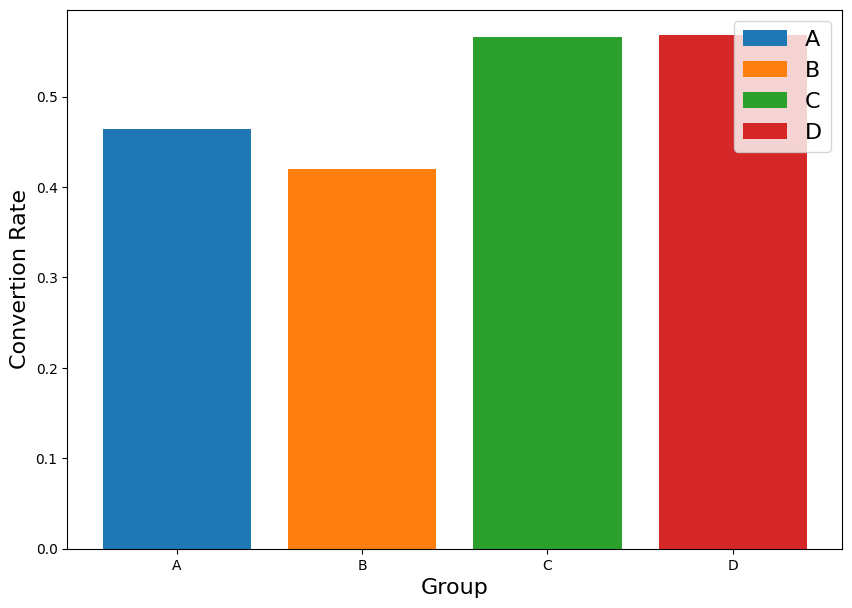

In [82]:
# visualisasi perbandingan convertion rate tiap grup
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# Buat plot
ax.bar("A", cr_A, label="A")
ax.bar("B", cr_B, label="B")
ax.bar("C", cr_C, label="C")
ax.bar("D", cr_D, label="D")

# Styling plot
ax.set_ylabel("Convertion Rate", fontsize=16)
ax.set_xlabel("Group", fontsize=16)

plt.legend(fontsize=16)
plt.show();

In [83]:
df_total = pd.concat([data_A,data_B,data_C,data_D])
df_total

,customer_id,OfferId,difficulty,reward,duration,channels,groups,conver
7841,50d964e03e2d4b52ba7d8265e3d9f18a,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
5801,3c765494acae43d48f69cc29794dfa1a,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
8451,56ce169a5a5b47e1b2028c663d3a11eb,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
19130,c13cd223575f47ff8fa7f53bd99b5cd8,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
43281,0e1bcbaa5ca64055a1ebc360886b1c17,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,1
...,...,...,...,...,...,...,...,...
17915,b4d6477e15ca4b1086638089882177b7,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
7183,4a6b6b268e7b4c6ebf96bc92cd67cf0f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
8605,58a2e3a01a5743d4900d6ad067f515f7,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
47576,54be86b2561e4e379e6446663e4d8935,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,1


In [84]:
df_total

,customer_id,OfferId,difficulty,reward,duration,channels,groups,conver
7841,50d964e03e2d4b52ba7d8265e3d9f18a,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
5801,3c765494acae43d48f69cc29794dfa1a,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
8451,56ce169a5a5b47e1b2028c663d3a11eb,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
19130,c13cd223575f47ff8fa7f53bd99b5cd8,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,0
43281,0e1bcbaa5ca64055a1ebc360886b1c17,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,"['email', 'mobile', 'social']",A,1
...,...,...,...,...,...,...,...,...
17915,b4d6477e15ca4b1086638089882177b7,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
7183,4a6b6b268e7b4c6ebf96bc92cd67cf0f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
8605,58a2e3a01a5743d4900d6ad067f515f7,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,0
47576,54be86b2561e4e379e6446663e4d8935,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",D,1


In [118]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


# Menggabungkan semua data dalam satu DataFrame
data_total = pd.concat([data_A, data_B, data_C, data_D])
data_total['conversion_rate'] = data_total['conver']

# Menjalankan ANOVA
model = ols('conversion_rate ~ C(groups)', data=data_total).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)

                sum_sq       df           F        PR(>F)
C(groups)   103.296338      3.0  140.020378  5.627308e-90
Residual   6176.221975  25116.0         NaN           NaN


In [119]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [120]:
# Menjalankan uji Tukey's HSD
tukey_result = pairwise_tukeyhsd(endog=data_total['conver'], groups=data_total['groups'], alpha=0.05)

# Menampilkan hasil
print(tukey_result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B  -0.0443    0.0  -0.067 -0.0215   True
     A      C   0.1011    0.0  0.0784  0.1239   True
     A      D   0.1033    0.0  0.0806  0.1261   True
     B      C   0.1454    0.0  0.1226  0.1681   True
     B      D   0.1476    0.0  0.1249  0.1703   True
     C      D   0.0022 0.9944 -0.0205   0.025  False
----------------------------------------------------


# Analyzing and Interpreting the Data

### Ensure the trustworthiness
**Some mechanism to Ensure Trustworthiness are :**
1. Validate data quality
2. Avoid threat to internal validity
3. Avoid threat to external validity
4. Mitigate the effect of simpson’s paradox

#### **Data Quality**

We can use the following checklist to measure data quality :
- Missing rates : How much missing value in dataset
- Uniqueness : No duplicate data
- Invalid values : Do the values follow the proper format? Are the values valid for the variable/column?
- Data delays : How many data is there at the periode of the experiment? How long does it take between when the events were logged and when the data is available for analysis?


#### Handle the NaN Data

In [85]:
for col in df_total.columns:
    print(df_total[col].value_counts(dropna = False))
    print("")

customer_id
50db32c4a95345ab93b8b5119f819970    6
abcc3cffbf8b483bad88116fe6ee3cd5    6
47849ffd86e34e40a763bb66ad81fbb1    5
6690f94587ec4b50abda164a6dc6d99a    5
064fd993498c4d628348de2085e9d569    5
                                   ..
8f45a5974df34ff3898cb0fa61d28dcc    1
ad1f0a409ae642bc9a43f31f56c130fc    1
0951cc66d2f841e99cce016730c3f6da    1
b3b653c27e1d40139b88c05cedd25000    1
54be86b2561e4e379e6446663e4d8935    1
Name: count, Length: 14138, dtype: int64

OfferId
ae264e3637204a6fb9bb56bc8210ddfd    6280
4d5c57ea9a6940dd891ad53e9dbe8da0    6280
9b98b8c7a33c4b65b9aebfe6a799e6d9    6280
f19421c1d4aa40978ebb69ca19b0e20d    6280
Name: count, dtype: int64

difficulty
10.0    12560
5.0     12560
Name: count, dtype: int64

reward
10.0    12560
5.0     12560
Name: count, dtype: int64

duration
7.0    12560
5.0    12560
Name: count, dtype: int64

channels
['web', 'email', 'mobile', 'social']    12560
['email', 'mobile', 'social']            6280
['web', 'email', 'mobile']            

- Sanity check

In [86]:
for col in df_total.columns:
    print(df_total[col].value_counts(dropna = False))
    print("")

customer_id
50db32c4a95345ab93b8b5119f819970    6
abcc3cffbf8b483bad88116fe6ee3cd5    6
47849ffd86e34e40a763bb66ad81fbb1    5
6690f94587ec4b50abda164a6dc6d99a    5
064fd993498c4d628348de2085e9d569    5
                                   ..
8f45a5974df34ff3898cb0fa61d28dcc    1
ad1f0a409ae642bc9a43f31f56c130fc    1
0951cc66d2f841e99cce016730c3f6da    1
b3b653c27e1d40139b88c05cedd25000    1
54be86b2561e4e379e6446663e4d8935    1
Name: count, Length: 14138, dtype: int64

OfferId
ae264e3637204a6fb9bb56bc8210ddfd    6280
4d5c57ea9a6940dd891ad53e9dbe8da0    6280
9b98b8c7a33c4b65b9aebfe6a799e6d9    6280
f19421c1d4aa40978ebb69ca19b0e20d    6280
Name: count, dtype: int64

difficulty
10.0    12560
5.0     12560
Name: count, dtype: int64

reward
10.0    12560
5.0     12560
Name: count, dtype: int64

duration
7.0    12560
5.0    12560
Name: count, dtype: int64

channels
['web', 'email', 'mobile', 'social']    12560
['email', 'mobile', 'social']            6280
['web', 'email', 'mobile']            

- Tidak dilakukan remove duplicate disebabkan bahwa setiap user atau customer dapat mendapatkan 1 atau lebih rewards(Offer)

### **Data Exploration**

In [87]:
# Percentage in each group
n_total = df_total.shape[0]
persen_A = n_A/n_total * 100 # Control
persen_B = n_B/n_total * 100 # Treatment 1
persen_C = n_C/n_total * 100 # Treatment 2
persen_D = n_D/n_total * 100 # Treatment 3

print(f"% A   : {persen_A:.2f}%")
print(f"% B   : {persen_B:.2f}%")
print(f"% C   : {persen_C:.2f}%")
print(f"% D   : {persen_D:.2f}%")

% A   : 25.00%
% B   : 25.00%
% C   : 25.00%
% D   : 25.00%


### **3. Sample Ratio Mismatch (SRM)**
* Sample Ratio Mismatch (SRM) is the situation when the observed sample ratio in the experiment is different from the expected.

* **Chi-square test** can be used to detect whether an experiment has SRM or not.

The steps for doing a chi-square test in order to detect SRM are:
1. Define the null and alternative hypothesis (H0 and H1)
2. Calculate chi-square statistics
3. Define decision rules
4. Make decisions and draw a conclusion


### Chi-Square Test for Detect SRM

The steps for doing a chi-square test in order to detect SRM are:

**1. Define the null and alternative hypothesis ($H_0$ and $H_1$)**

$H_0$  : No SRM detected

$H_1$  : SRM detected

**2. Calculate chi-square statistics**

$$ \chi^2 = \sum \frac{\left ( \text{observed - expected} \right )^2}{\text{expected}} $$

Where :
- Observed: the control and variation traffic volumes (sample size), respectively
- Expected: the expected values for control and treatment — i.e. the total observed divided by 4


Observed is the same as # user in each group.

For calculate expexted in each group, we can use total observed divided by 4


In [90]:
observed = [ n_A, n_B, n_C, n_D ]
total_traffic= sum(observed)
expected = [ total_traffic/4, total_traffic/4, total_traffic/4, total_traffic/4 ]

Then we can calculate the chi-square statistics using the function in the `scipy` library, namely `chisquare` with steps: 

1. import library
  - from scipy.stats import chisquare
2. Use the function `chisquare(f_obs, f_exp=...)`
    - `f_obs`: Observed frequencies in each category (array)
    - `f_exp`: Expected frequencies in each category. By default the categories are assumed to be equally likely.

In [91]:
#calculate chi-square statistics
from scipy.stats import chisquare
chi = chisquare(observed, f_exp=expected)
print(chi)

Power_divergenceResult(statistic=0.0, pvalue=1.0)


**3. Define decision rules**

In making statistical test decisions, we can use:
- Comparison of chi-square statistics with critical value
     -  $\chi^2 > \chi^2_{\alpha,df}$ → reject $H_0$

- Comparison of p-value with alpha
   - pvalue < $\alpha$ → reject $H_0$


Normally, one would look for a p-value of 0.05 or less to proof of SRM. The problem with 0.05 is that it’s not strict enough for our purposes. Using this might give us a false signal. What we need is to be stricter for our test. So we use significance level 1%.

degree of freedom (df) is calculated as: 
$$ df = (rows − 1) × (columns − 1) $$ 


In [92]:
# Comparison of chi-square statistics with critical value
# We must calculate the critical first

# critical value is the chi-square value at alpha
alpha = 0.01
df = len(observed) - 1  # untuk empat grup A, B, C, D, df harus 3
import scipy
chi_critical = scipy.stats.chi2.ppf(1 - alpha, df)
print(f"Critical value: {chi_critical:.3f}")

Critical value: 11.345


In [93]:
#Make decisions from chi-square statistics and critical value
if chi[0] > chi_critical:
  print("Reject H0 : SRM may be present.")
else:
  print("Fail to reject H0 : No SRM")

Fail to reject H0 : No SRM


In [94]:
# Comparison of P-Value with alpha.
if chi[1] < 0.01:
    print('Reject H0 : SRM may be present.')
else:
    print('Fail to reject H0 : No SRM.')

Fail to reject H0 : No SRM.


#### Conclusion

Based on data quality, we have done data cleaning so that the data we use is of sufficient quality. But we need to check again, whether the sample size after data cleaning is sufficient (according to the experimental design) or not so that there is enough power to draw credible conclusions.

Based on the detection of SRM, although the sample size of the cleaned data is different. However, SRM was not detected.

### 2.	Hypothesis Testing and Analyzing the Result

In [95]:
def extract_evaluation(data):
    """
    Extract key evaluation criterion within the data
    - number of session
    - number of conversion
    - conversion rate
    :param data: <pandas DataFrame> sample data
    :return results: <dict> contain number of sess., number of conv., & conversion rate
    """
    # Number of session
    n_session = int(data.shape[0])

    # Number of conversion
    n_conversion = int(data["conver"].sum())

    # Conversion rate (in percent)
    conversion_rate = (n_conversion/n_session) * 100

    # Return results
    results = {}
    results["session"] = n_session
    results["conversion"] = n_conversion
    results["CVR"] = np.round(conversion_rate, 2)

    return results


In [96]:
res_A = extract_evaluation(data = data_A)
res_B = extract_evaluation(data = data_B)
res_C = extract_evaluation(data = data_C)
res_D = extract_evaluation(data = data_D)

In [97]:
print(f" A: {res_A}")
print(f" B: {res_B}")
print(f" C: {res_C}")
print(f" D: {res_D}")

 A: {'session': 6280, 'conversion': 2916, 'CVR': 46.43}
 B: {'session': 6280, 'conversion': 2638, 'CVR': 42.01}
 C: {'session': 6280, 'conversion': 3551, 'CVR': 56.54}
 D: {'session': 6280, 'conversion': 3565, 'CVR': 56.77}


#### Calculate lift-over-baseline

$$
\text{Lift} = CVR_{\text{treatment}} - CVR_{\text{control}}
$$

In [98]:
lift_B = res_B["CVR"] - res_A["CVR"]
lift_C = res_C["CVR"] - res_A["CVR"]
lift_D = res_D["CVR"] - res_A["CVR"]

In [99]:
print(f"Lift-overbaseline untuk treatment B adalah {lift_B} %")
print(f"Lift-overbaseline untuk treatment C adalah {lift_C} %")
print(f"Lift-overbaseline untuk treatment D adalah {lift_D} %")

Lift-overbaseline untuk treatment B adalah -4.420000000000002 %
Lift-overbaseline untuk treatment C adalah 10.11 %
Lift-overbaseline untuk treatment D adalah 10.340000000000003 %


####  **Multiple Hypothesis Testing with Benjamini-Hochberg Correction**

- To find out which one is the best, we can do a hypothesis testing.
- A suitable hypothesis test for this case is the z-test for proportion.
- Because we have more than two groups to compare, therefore we perform multiple hypothesis testing for each group pair.
- An issue with multiple hypothesis testing is increasing of Type I error, so we can do correction with Benjamini-Hochberg Correction 

**The following is the stage for conducting the analysis :**

##### 1. Define null hypothesis ($H_0$) and alternative hypothesis ($H_1$)

We want to compare whether group $i$ th is more than group $j$ th, so we use one sided (right tail) hypothesis testing.

we want to prove whether the conversion rate of group $j$ is greater than the conversion rate of group $i$

The hypothesis for each group pair is as follows:
- group 1 vs group 2
    $$H_0 : p_B \leq p_A$$
    $$H_1 : p_B > p_A$$

- group 1 vs group 3
    $$H_0 : p_C \leq p_A$$
    $$H_1 : p_C > p_A$$

- group 1 vs group 4
    $$H_0 : p_D \leq p_A$$
    $$H_1 : p_D > p_A$$

- group 2 vs group 3
    $$H_0 : p_C \leq p_B$$
    $$H_1 : p_C > p_B$$

- group 2 vs group 4
    $$H_0 : p_D \leq p_B$$
    $$H_1 : p_D > p_B$$

- group 3 vs group 4
    $$H_0 : p_D \leq p_C$$
    $$H_1 : p_D > p_C$$
    

- Set siginificance level (alpha)
- Significance level = 0.05

##### 2. Calculate the p-value in each test

In [100]:
#import library
from statsmodels.stats.proportion import proportions_ztest

# call function
#p-value group A vs group B hypotesis test
p_value_AB = proportions_ztest(count = [n_convertB, n_convertA],
                               nobs = [n_B, n_A],
                               alternative = 'larger')[1]

print(f"P-value A vs B: {p_value_AB:.4f}")

P-value A vs B: 1.0000


In [101]:
#p-value group A vs group C hypotesis test
p_value_AC = proportions_ztest(count = [n_convertC, n_convertA],
                               nobs = [n_C, n_A],
                               alternative = 'larger')[1]

print(f"P-value A vs C: {p_value_AC:.4f}")

P-value A vs C: 0.0000


In [102]:
#p-value group A vs group D hypotesis test
p_value_AD = proportions_ztest(count = [n_convertD, n_convertA],
                               nobs = [n_D, n_A],
                               alternative = 'larger')[1]

print(f"P-value A vs D: {p_value_AD:.4f}")

P-value A vs D: 0.0000


In [103]:
#p-value group B vs group C hypotesis test
p_value_BC = proportions_ztest(count = [n_convertC, n_convertB],
                               nobs = [n_C, n_B],
                               alternative = 'larger')[1]

print(f"P-value B vs C: {p_value_BC:.4f}")

P-value B vs C: 0.0000


In [104]:
#p-value group B vs group D hypotesis test
p_value_BD = proportions_ztest(count = [n_convertD, n_convertB],
                               nobs = [n_D, n_B],
                               alternative = 'larger')[1]

print(f"P-value B vs D: {p_value_BD:.4f}")

P-value B vs D: 0.0000


In [105]:
#p-value group C vs group D hypotesis test
p_value_CD = proportions_ztest(count = [n_convertD, n_convertC],
                               nobs = [n_D, n_C],
                               alternative = 'larger')[1]

print(f"P-value C vs D: {p_value_CD:.4f}")

P-value C vs D: 0.4005


In [106]:
# make dataframe consist of p-values
pair_group = ['B > A',
              'C > A',
              'D > A',
              'C > B',
              'D > B',
              'D > C']

p_vals = [p_value_AB, p_value_AC,
          p_value_AD, p_value_BC,
          p_value_BD, p_value_CD]

df_p_vals = pd.DataFrame({'pair_group': pair_group,
                          'p-value': p_vals})

#print
df_p_vals_order = df_p_vals.sort_values(by=['p-value'])

##### Assign ranks to the ordered p-values.

In [107]:
df_p_vals_order['rank'] = df_p_vals_order['p-value'].rank().sub(0).astype(int)
df_p_vals_order

,pair_group,p-value,rank
4,D > B,8.804601e-62,1
3,C > B,5.364431e-60,2
2,D > A,2.374838e-31,3
1,C > A,4.297854e-30,4
5,D > C,4.004879e-01,5
0,B > A,9.999997e-01,6


#### Calculate each individual p-value’s Benjamini-Hochberg critical value

Using the formula :

$$\text{BH-critical value} = \left ( \frac{i}{m} \right )Q$$


where:
- $i$ = the p-value’s rank
- $m$ = total number of tests
- $Q$ = the false discovery rate (chosen by the experimenter)

- Suppose that, the experimenter want to control false discoverry rate in 5%. So the $Q=0.05$

In [108]:
#define Q
Q = 0.05

#calculate BH-critical value
df_p_vals_order['BH-crit'] = df_p_vals_order['rank']/len(df_p_vals_order)*Q

#print
df_p_vals_order

,pair_group,p-value,rank,BH-crit
4,D > B,8.804601e-62,1,0.008333
3,C > B,5.364431e-60,2,0.016667
2,D > A,2.374838e-31,3,0.025000
1,C > A,4.297854e-30,4,0.033333
5,D > C,4.004879e-01,5,0.041667
0,B > A,9.999997e-01,6,0.050000


##### Compare original p-values to the Benjamini-Hochberg critical value 

If the original p-values smaller than Benjamini-Hochberg critical, then the test are significant (reject $H_0$)


In [109]:
# make new column with condition
df_p_vals_order['Significant?'] = np.where(df_p_vals_order['p-value'] < df_p_vals_order['BH-crit'],
                                           'Yes',
                                           'No')

#print
df_p_vals_order

,pair_group,p-value,rank,BH-crit,Significant?
4,D > B,8.804601e-62,1,0.008333,Yes
3,C > B,5.364431e-60,2,0.016667,Yes
2,D > A,2.374838e-31,3,0.025000,Yes
1,C > A,4.297854e-30,4,0.033333,Yes
5,D > C,4.004879e-01,5,0.041667,No
0,B > A,9.999997e-01,6,0.050000,No


**Conclusion**
- D tampaknya sangat unggul dalam perbandingan yang signifikan, terutama terhadap B dan A.
- C juga menunjukkan performa yang baik, terutama dalam perbandingan terhadap B dan A.

Jadi, D dan C mungkin dianggap sebagai grup yang lebih baik berdasarkan perbandingan signifikan ini.

#### Confidence interval of difference between Treatment and Control

After that, we will calculate the confidence interval to estimate within what range the difference or proportion discrepancy in the population lies

In [110]:
from statsmodels.stats.proportion import confint_proportions_2indep

confidence_interval_AB = confint_proportions_2indep(count1 = n_convertB, nobs1 = n_B,
                                                 count2 = n_convertA, nobs2 = n_A, 
                                                 compare='diff', alpha=0.05)
print(f"Difference A vs B: {confidence_interval_AB}")

Difference A vs B: (-0.06159750261643404, -0.026899777909596117)


In [111]:
confidence_interval_AC = confint_proportions_2indep(count1 = n_convertC, nobs1 = n_C,
                                                 count2 = n_convertA, nobs2 = n_A, 
                                                 compare='diff', alpha=0.05)
print(f"Difference A vs C: {confidence_interval_AC}")

Difference A vs C: (0.08368513114807757, 0.1184568291438987)


In [112]:
confidence_interval_AD = confint_proportions_2indep(count1 = n_convertD, nobs1 = n_D,
                                                 count2 = n_convertA, nobs2 = n_A, 
                                                 compare='diff', alpha=0.05)
print(f"Difference A vs D: {confidence_interval_AD}")

Difference A vs D: (0.08591868831249476, 0.12067995770193314)


In [113]:
confidence_interval_BC = confint_proportions_2indep(count1 = n_convertC, nobs1 = n_C,
                                                 count2 = n_convertB, nobs2 = n_B, 
                                                 compare='diff', alpha=0.05)
print(f"Difference B vs C: {confidence_interval_BC}")

Difference B vs C: (0.12802364015214523, 0.16261502935871716)


In [114]:
confidence_interval_BD = confint_proportions_2indep(count1 = n_convertD, nobs1 = n_D,
                                                 count2 = n_convertB, nobs2 = n_B, 
                                                 compare='diff', alpha=0.05)
print(f"Difference B vs D: {confidence_interval_BD}")

Difference B vs D: (0.13025721473444443, 0.16483811875852816)


In [115]:
confidence_interval_CD = confint_proportions_2indep(count1 = n_convertD, nobs1 = n_D,
                                                 count2 = n_convertC, nobs2 = n_C, 
                                                 compare='diff', alpha=0.05)
print(f"Difference C vs D: {confidence_interval_CD}")

Difference C vs D: (-0.015099372425550504, 0.019556078589053533)


In [116]:
confidence_interval_AB = list(confidence_interval_AB)
confidence_interval_AC = list(confidence_interval_AC)
confidence_interval_AD = list(confidence_interval_AD)
confidence_interval_BC = list(confidence_interval_BC)
confidence_interval_BD = list(confidence_interval_BD)
confidence_interval_CD = list(confidence_interval_CD)

index = ['confidence_interval_AB','confidence_interval_AC','confidence_interval_AD','confidence_interval_BC',
         'confidence_interval_BD','confidence_interval_CD']

confidence_interval = [confidence_interval_AB, confidence_interval_AC, confidence_interval_AD,
                      confidence_interval_BC, confidence_interval_BD, confidence_interval_CD]

df_ci = pd.DataFrame(confidence_interval, columns = ["lower","upper"])
df_ci = df_ci.set_index([index])

Based on these results, we are 95% confident that the difference in proportion of users who converted between the treatment group (B) and the control group (A) can be seen in the table below.

Or it can be said that the increase in conversion rate using the Creative Ad method (treatment) has increased according to the table below.

In [117]:
df_ci

,lower,upper
confidence_interval_AB,-0.061598,-0.026900
confidence_interval_AC,0.083685,0.118457
confidence_interval_AD,0.085919,0.120680
confidence_interval_BC,0.128024,0.162615
confidence_interval_BD,0.130257,0.164838
confidence_interval_CD,-0.015099,0.019556
